In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
import json
from scipy import stats
import random
##
import os
from glob import glob


In [3]:
import  EDA_Functions

In [4]:
import shapely 

In [29]:
df = pd.read_csv('Data/Point_OpticalNDVI.csv').drop(columns = ['Unnamed: 0'])
hm = pd.read_csv('Data/Annotated_hm_NDVI.csv').drop(columns = ['Unnamed: 0']) 
#hmt = pd.read_csv("Data/hm_v5_2023_temperatures.csv").drop(columns = ['Unnamed: 0'])

In [30]:
df = pd.merge(df,hm , how ='inner' , on = 'Unique_Id')

In [31]:
# getting tmax ndvi
dates = sorted([col.split('_')[0] for col in df.columns if 'NDVI' in col] )
cols = [val+'_NDVI' for val in dates]
datesinv = {dates[i]:i for i in range(len(dates))}
datesinv

maxndvi = []
tmaxndvi = [] 
for rownum,row in df.iterrows():
    tmaxndvi.append(datesinv[row[cols].idxmax().split('_')[0]])
df['t_max_NDVI'] = tmaxndvi

In [26]:
# Getting latitude

new = []
for val in df['.geo']:
    da = json.loads(val)
    if('coordinates'  in da): # Different way the geometry is stored.
        fir = da['coordinates'][0] 
        try:  # There are different shapes. 
            da = shapely.centroid(shapely.Polygon(da['coordinates'][0])) 
        except:
            da = shapely.centroid(shapely.Polygon(da['coordinates'][0][0])) 
        new.append([da.x , da.y])
    else:
        take = da['geometries']
        okay = False
        for shot  in take:
            if(shot['type'] == 'Polygon'):
                da = shapely.centroid(shapely.Polygon(shot['coordinates'][0])) 
                new.append([da.x , da.y])
                okay = True
                break 
        if(not okay):
            print([shot['type'] for short in take])
            raise Exception("Polygon not found")

df['centroid'] = new
df['lat'] = df['centroid'].apply(lambda x: x[1])
df['lat'] = df['lat'].apply(lambda x: round(x , 2))


In [32]:
np.unique(df.Class_st)

array(['Fallow', 'Non_crop', 'Rapeseed', 'Summer_cro', 'Winter_cer'],
      dtype=object)

Text(0, 0.5, 'Latitude')

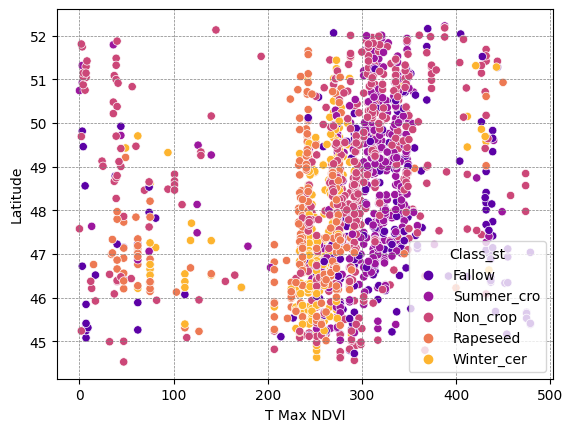

In [47]:
#df0 =  df[df.Class_st == 'Rapeseed']
df0 = df.copy()
x = df0['lon']
y = df0['lat']

plt.grid(color='gray', linestyle='--', linewidth=0.5) 
#plt.scatter( x , y ,marker = 'x')
sns.scatterplot(data = df0 ,x='t_max_NDVI',y='lat',hue='Class_st',palette='plasma')
plt.xlabel("T Max NDVI")
plt.ylabel("Latitude")


In [92]:
df = pd.read_csv('Data/Optical_Point01.csv').drop(columns = ['Unnamed: 0'])
df = df[df.Crop_Type == 'Winter_cer']
samples = df.sample(n=3)

for rownum , sample in samples.iterrows():
    cols = [col for col in sample.index if 'NDVI' in col]
    sendevi = sample[cols]
    
    maxi = 0 
    maxx = 0
    for i in range(100):
        if(str(i)+'__NDVI' not in sample):
            break
        if(sample[str(i)+'__NDVI'] > maxx):
            maxx = sample[str(i)+'__NDVI']
            maxi = i 
    print(maxx,maxi) 
    print(sample['t_max_NDVI'])
    
    
    


0.1101436265709156 31
31
0.146829810901001 23
23
0.0895011705384476 24
24


<Axes: xlabel='avg_temp', ylabel='lat'>

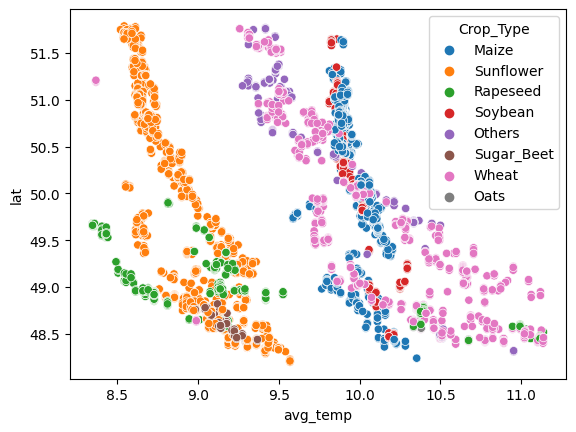

In [77]:
sns.scatterplot(data = df0 ,x='avg_temp',y='lat',hue='Crop_Type')

Text(0, 0.5, 'Latitude')

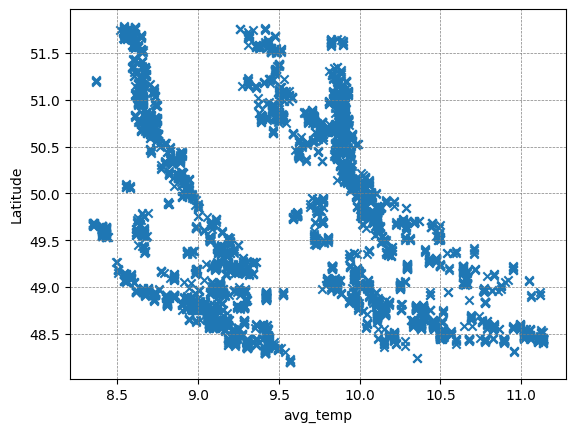

In [35]:
df['avg_temp'] = df[[col for col in df if 'GDD' in col]].mean(axis=1)
df0 = df.copy()
#df0 =  df[df.Crop_Type == 'Soybean']
x = df0['avg_temp']
y = df0['lat']

plt.grid(color='gray', linestyle='--', linewidth=0.5) 
plt.scatter( x , y ,marker = 'x')
plt.xlabel("avg_temp")
plt.ylabel("Latitude")


## 1.SINGLE AGGREGATIONS

### 1.1 Same time, Same bands, Multiple points

In [10]:
# 1. describe band
def single(df, time,band):
    df = EDA_Functions.single_timestep(df,time = time,other=False)
    return df[band]
    
df = time_df
print(single(df , 2,'NDVI').describe())
print(single(df , 18,'B3').describe())


count    4632.000000
mean        4.878398
std         1.032765
min         2.297750
25%         4.183497
50%         4.785813
75%         5.477125
max         9.324000
Name: B3, dtype: float64


In [7]:
# 2. check empty bands 

df = time_df
null_columns = df.columns[df.isnull().all()].tolist()
print(null_columns)
assert len(null_columns) == 0

[]


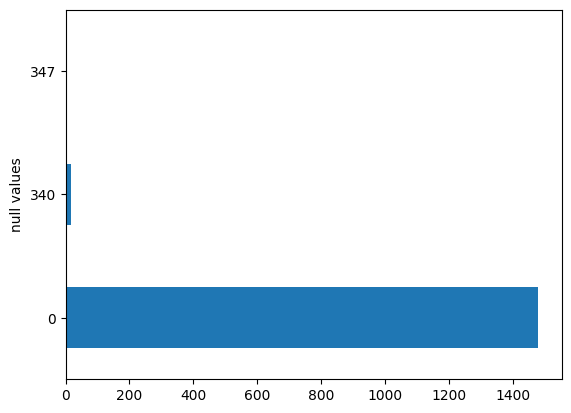

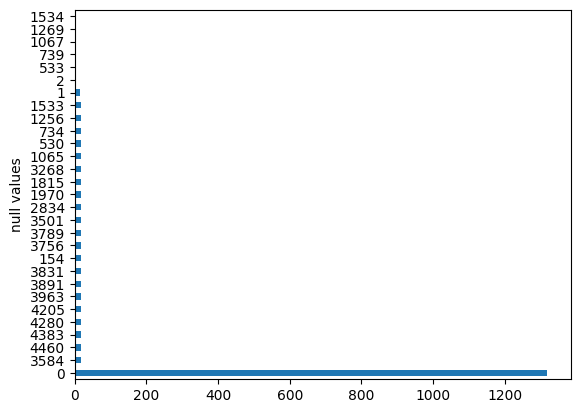

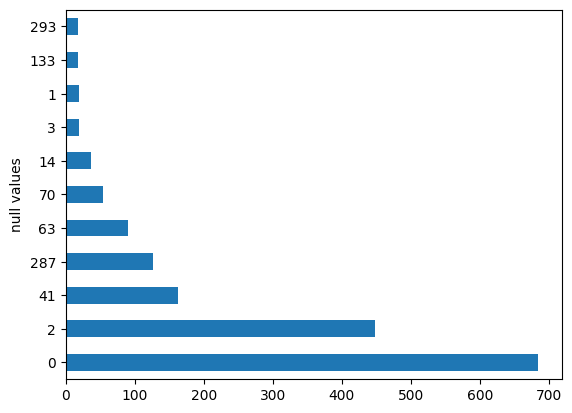

In [17]:
# 3. Null value histogram. 

def null_hist(df):
    a = df.isnull().sum()
    a.name = 'null values'
    EDA_Functions.bar_hist(pd.DataFrame(a) , col = 'null values')
    plt.show()
null_hist(time_df)
null_hist(cgdd_df)
null_hist(df3)

Text(0.5, 1.0, 'Scatter plot of 8__B3')

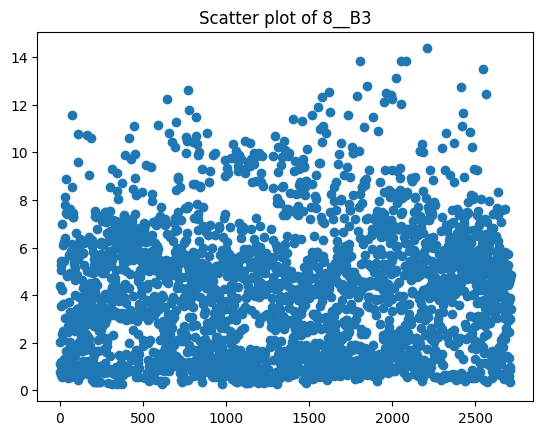

In [19]:
# Single band scatter plot. 
# Mind the range ,  it is supposed to look uniform across x axis. 
time = 8
band = 'B3'
s = single(df3,time,band)
plt.scatter(range(len(s)) , s)
plt.title(f'Scatter plot of {time}__{band}')

# Observation - CGDD values aren't as tight as time values , suggesting they aren't being computed correctly. 


In [35]:
cgdd_df['29__CLDPRB']

0       100.0
1       100.0
2         0.0
3         0.0
4       100.0
        ...  
4475      0.0
4476    100.0
4477      0.0
4478     65.0
4479     65.0
Name: 29__CLDPRB, Length: 4480, dtype: float64

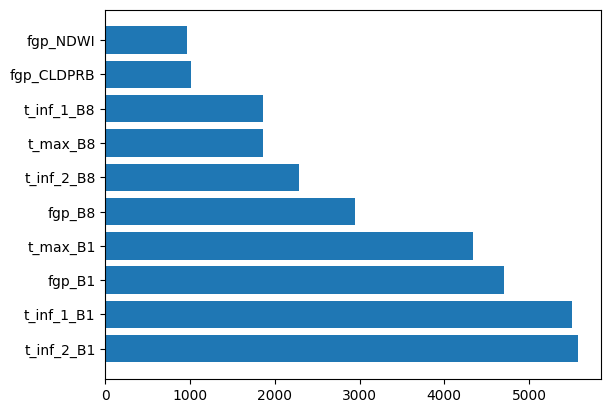

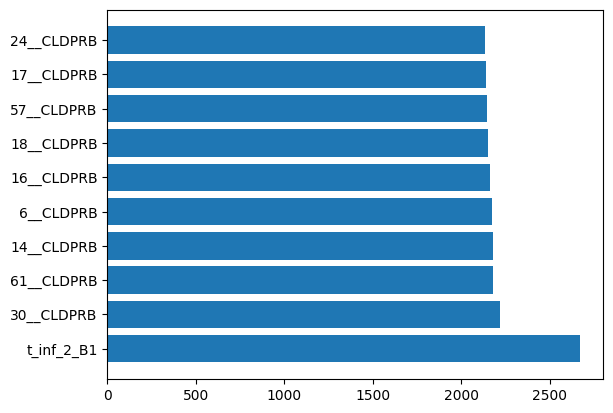

In [25]:
def top_variance(df,n):
    df = df[EDA_Functions.get_numeric_columns(df)]
    topn = df.var().sort_values(ascending=False).head(n)
    plt.barh(topn.index,topn.values)
    plt.show()
top_variance(time_df , 10)
top_variance(cgdd_df , 10)


In [ ]:
n = 5

# Calculate variance for each column, sort in descending order, and get top n columns
top_n_columns = numeric_df.var().sort_values(ascending=False).head(n).index
# Plotting the top n columns
numeric_df[top_n_columns].plot(kind="bar", figsize=(8, 6))
plt.xlabel("Index")
plt.ylabel("Values")
plt.title(f"Top {n} Columns with Highest Variance")
plt.show()

In [ ]:
ctype = 'Rapeseed'
time = 10
band = 'NDVI' 
EDA_Functions.single_timestep(df[df.Crop_Type == ctype],time = timestep,other=False)[band].describe()

### Unsupervised

### Supervised

## DOUBLE AGGREGATIONS

### Unsupervised

### Supervised

In [ ]:
timesteps = [0,1,2,3,4,5,6,7,8,9,10]
months = ['Oct 22','Nov 22','Dec 22','Jan 23','Feb 23','Mar 23','Apr 23','May 23', 'Jun 23', 'July 23','Aug 23']


In [ ]:
from EDA_Functions import plot_skewness 

In [ ]:
plot_skewness(numeric_df)

## Functions

In [12]:
time

8

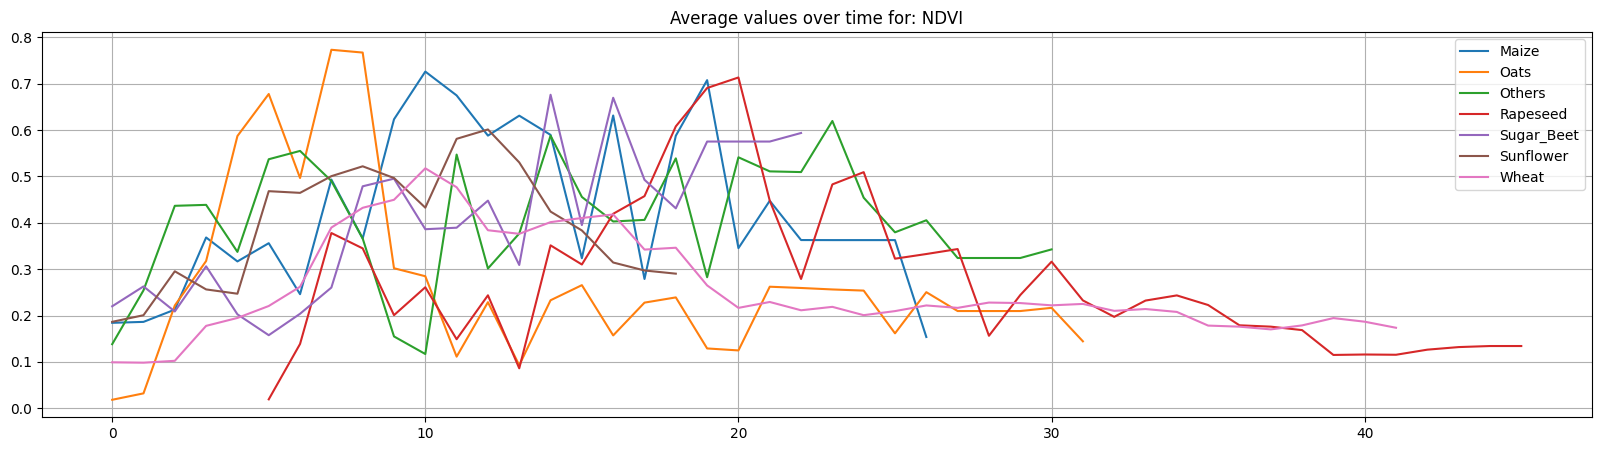

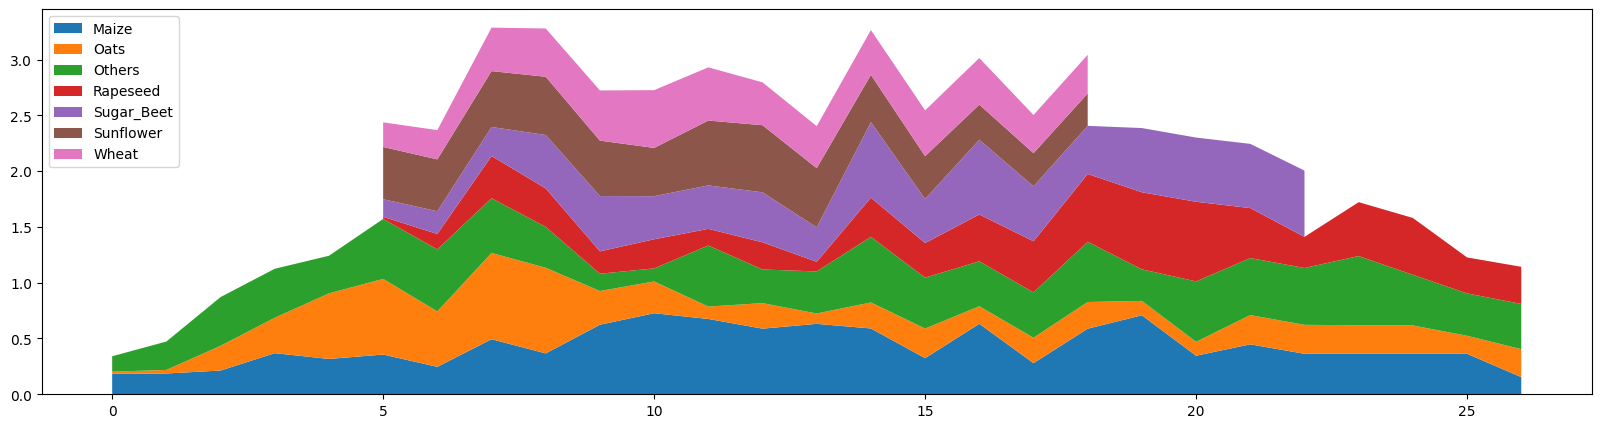

In [35]:

EDA_Functions.band_series_by_croptype(df6 , 'NDVI')

## gdd doesn't look good. you need to redo it.
# also, try to see how accuracy varies with region, especially if you train on 1 and res tin other. 
## gdd has a chance of working better trhere.

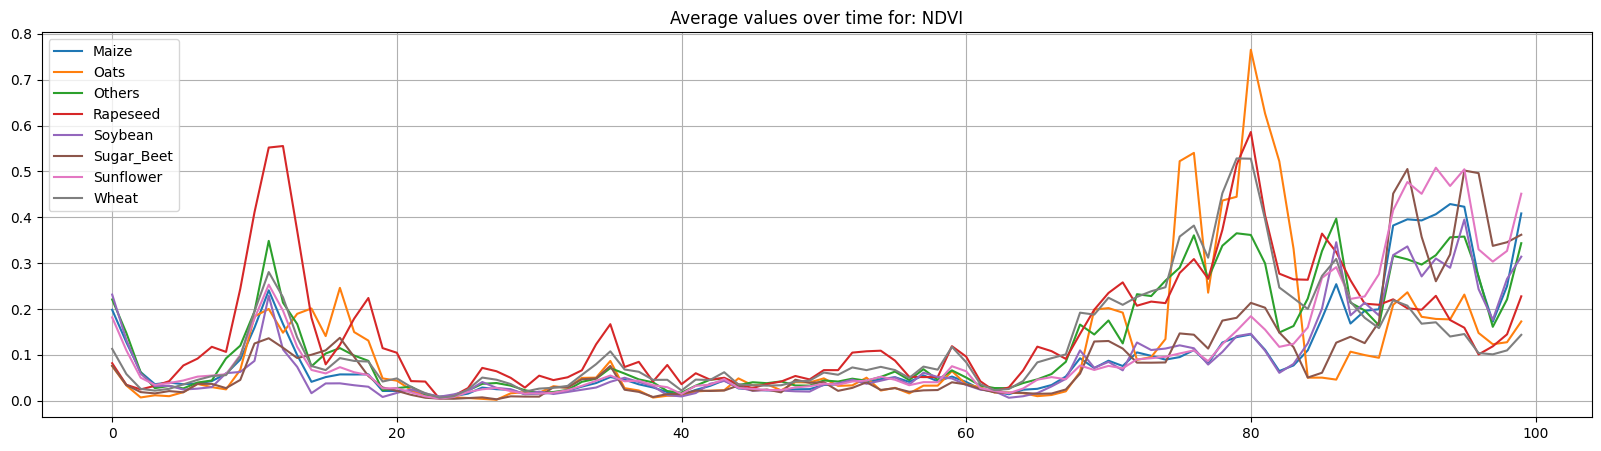

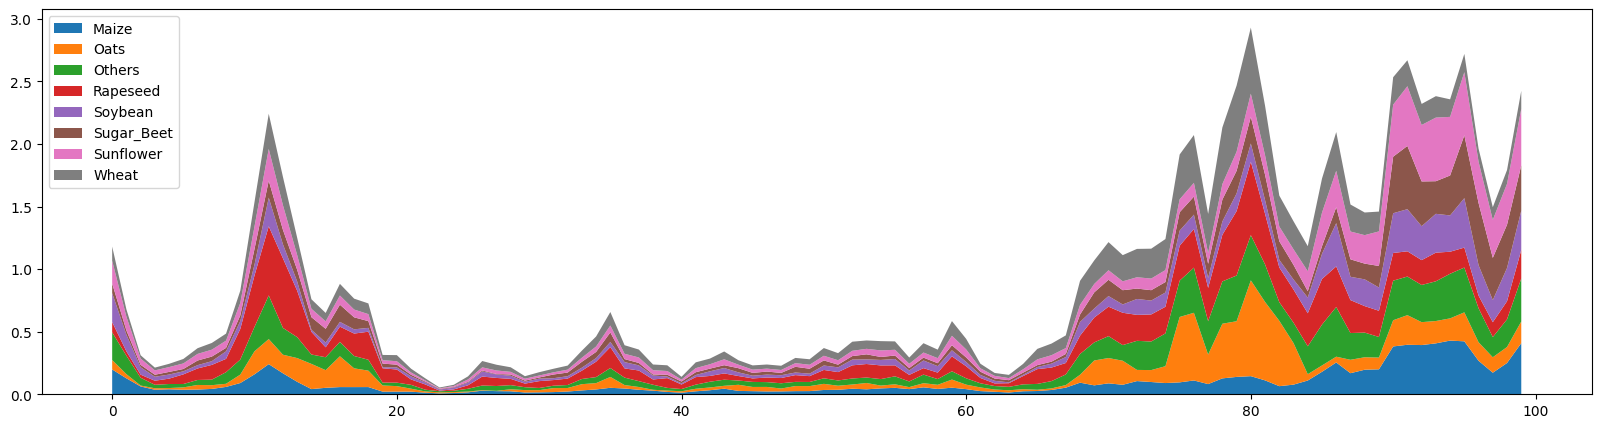

In [12]:
band_series_by_croptype(df,'NDVI')

C:\Users\kashy\anaconda3\envs\RemoteSensing\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kashy\anaconda3\envs\RemoteSensing\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kashy\anaconda3\envs\RemoteSensing\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kashy\anaconda3\envs\RemoteSensing\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

([0.11317554877715703,
  0.05821131945819352,
  0.026031545990053428,
  0.02214132843124746,
  0.026032975960291665,
  0.03577258442626752,
  0.04561831927062282,
  0.05381553358713278,
  0.05599315846065426,
  0.09714811233855002,
  0.19538932169160128,
  0.2806731343268393,
  0.22577232032045103,
  0.13801468729257885,
  0.07585009101967609,
  0.06688761120200414,
  0.0930703372509185,
  0.08688007098386619,
  0.08550711054624369,
  0.041986862799845655,
  0.04882517814171075,
  0.03012866923597403,
  0.016524193254355713,
  0.006648107899247343,
  0.009995682410563138,
  0.024804744132133728,
  0.05062777403375447,
  0.04596142786976725,
  0.03650522320598694,
  0.01998825018159081,
  0.02654089210142227,
  0.028369851719962463,
  0.03245084983650987,
  0.05643057625555192,
  0.07980038333922432,
  0.10785146919983446,
  0.0682327518431724,
  0.06327383496637894,
  0.04559025645067538,
  0.04576100441471495,
  0.022456976988719433,
  0.04614144525012158,
  0.045321734341126275,
  0.

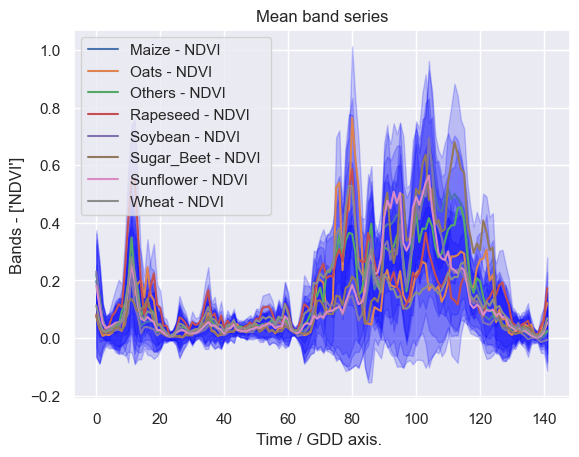

In [15]:
plot_mean_std(df,bands = ['NDVI'], croptypes = np.unique(df.Crop_Type))

In [9]:
## Helper functions

#print(single_timestep(sampled0,3))


def get_sample_timeseries(df,index,bands,fid=False,plot=False):
  '''
  Use this function to get several time series.
  -> Index can be a list of indexes, bands can be a list of bands
  If fid is True, use index as fid instead of Dataframe index. (This is useful for getting all NSamples )

  If there are multiple bands, use different figures for plotting,.

  Return type is a 3d numpy array. 1st dimension is the bands. 2nd is the indexes. 3rd is the timeseries.

  FUTURE: implement color scheme for fid- TRUE and multiple indexes.

  '''
  if(type(index)==int):
    index = [index]  #Make sure index is always a list, as we want newdf to always be a dataframe (and not a series)
  if(type(bands)==str):
    bands  = [bands]

  if(fid):
    newdf = df[df['fid'].isin(index)]
  else:
    newdf = df.iloc[index]

  return_array = []
  newdf = newdf.reset_index(drop=True)
  band_figure = 0
  for band in bands: #runs atleast once.
    if(plot):
      band_figure += 1
      plt.figure(band_figure)
      plt.title("BAND:{}".format(band))
    columns = [str(time)+'_'+band for time in timesteps]
    single_band = newdf[columns]
    l = []
    for row in single_band.iterrows():
      l.append(row[1].values)
      plt.plot(months, row[1] , label = row[0] ) if plot else 0


    plt.legend() if not fid else -1 , plt.show() if plot else 0
    # Plot only if plot is True. Additionally, if fid is true, don't add legend, because it's cluttered.

    return_array.append(l)
  return np.array(return_array)







## Data preprocessing
# Everything about changing the actual data.


<Axes: ylabel='CropName'>

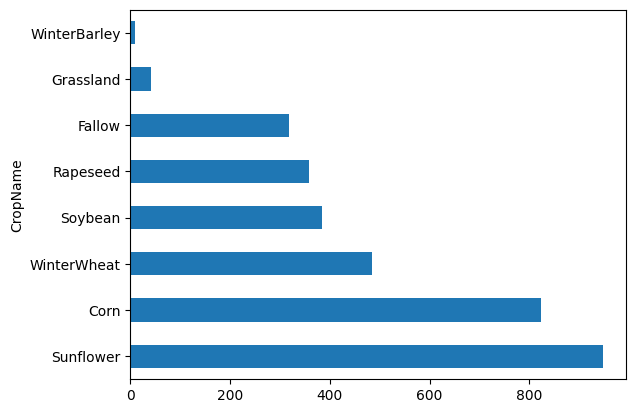

### Part 1: Unsupervised


#### Skewness of columns

In [41]:
COLS = [col for col in Train_1.columns if re.match(r'[0-9]',col)]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


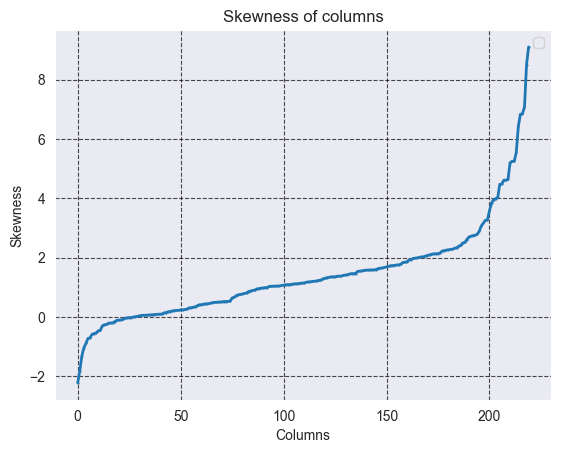

In [42]:
# Skewness of columns
cols = Train_1[COLS].skew().sort_values()
mi  = cols[:10]
ma = cols[-10:]
mid = cols[len(cols)//2 - 5 : len(cols)//2+5]
sns.set_style("darkgrid")
plt.plot(cols.values,linewidth=2, marker='.', markersize=1)
plt.title("Skewness of columns")
plt.grid(True,color='Black',linestyle='--', alpha=0.7)
plt.xlabel('Columns')
plt.ylabel('Skewness')
plt.legend()

In [37]:
highskew = list(mi.index.values) +  list(ma.index.values)
lowskew = list(mid.index.values)

In [38]:
lowskew

['1_B12',
 '10_B12',
 '7_NDRE',
 '0_B5',
 '7_VV',
 '1_B11',
 '7_B9',
 '8_B6',
 '9_B11',
 '0_B8A']

C:\Users\kashy\anaconda3\envs\RemoteSensing\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


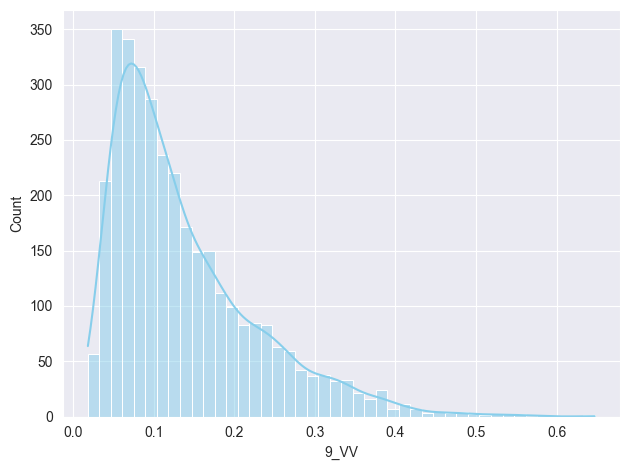

In [39]:
plot_histogram(Train_1[['9_VV']])

#### Outliers in each column

#### Variance

In [44]:
Train_1[COLS].var().sort_values()

3_VH        0.000015
4_VH        0.000018
5_VH        0.000021
2_VH        0.000032
1_VH        0.000050
             ...    
7_VV_VH    43.064520
3_VV_VH    45.907045
6_VV_VH    51.890553
2_VV_VH    53.777290
4_VV_VH    64.934957
Length: 220, dtype: float64

C:\Users\kashy\AppData\Local\Temp\ipykernel_11212\3372657011.py:1: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.lineplot(Train_1.var().sort_values().values)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


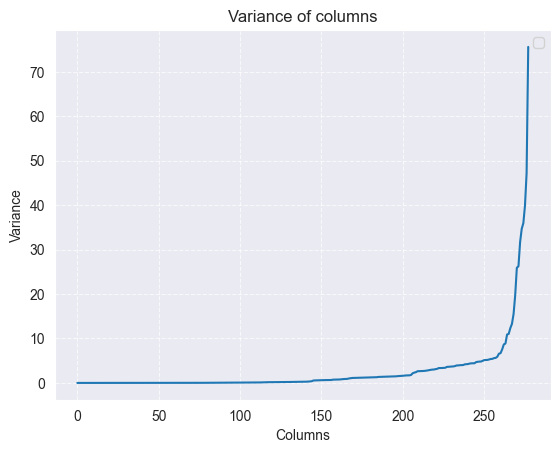

In [22]:
sns.lineplot(Train_1.var().sort_values().values)
plt.title("Variance of columns")
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Columns')
plt.ylabel('Variance')
plt.legend()

#### Timeseries


### Part 2: w.r.t target column

In [31]:
Train_1[highskew].corrwith(Train_1.CropCode).sort_values

<bound method Series.sort_values of t_max_SAVI   -0.376460
t_max_NDVI   -0.379061
t_max_NDRE   -0.389489
inf_1_NDWI   -0.058000
2_NDWI       -0.136799
t_max_NDYI   -0.336783
4_NDWI       -0.033478
1_NDWI       -0.223138
fgp_NDRE      0.078076
max_NDVI     -0.137902
8_B3         -0.008032
0_B1          0.090238
7_B2         -0.213499
7_B1         -0.206794
9_B4          0.168612
9_B5          0.173584
9_B1          0.029573
9_B2          0.053434
9_B3          0.069580
4_VV_VH      -0.068735
dtype: float64>

In [32]:
Train_1[lowskew].corrwith(Train_1.CropCode).sort_values

<bound method Series.sort_values of 7_B7            0.482176
7_VV_VH        -0.402506
10_B4           0.306373
10_B11          0.350533
3_B11          -0.017459
7_B6            0.479266
t_inf_2_NDYI    0.111770
7_VV            0.080139
10_VV          -0.294887
mean_NDRE       0.429994
dtype: float64>

In [33]:
Train_1.drop(columns = ['CropCode']).corrwith(Train_1.CropCode).sort_values()

C:\Users\kashy\AppData\Local\Temp\ipykernel_11212\3596959069.py:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Train_1.drop(columns = ['CropCode']).corrwith(Train_1.CropCode).sort_values()


VisualCode         -0.847673
minGradient_NDVI   -0.521864
minGradient_SAVI   -0.509217
7_B12              -0.505774
t_inf_1_NDRE       -0.500683
                      ...   
7_NDRE              0.498173
mean_SAVI           0.513882
mean_NDVI           0.517635
7_NDVI              0.525889
7_SAVI              0.527425
Length: 277, dtype: float64

C:\Users\kashy\AppData\Local\Temp\ipykernel_11212\4281777314.py:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.lineplot(Train_1.drop(columns = ['CropCode']).corrwith(Train_1.CropCode).sort_values().values)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


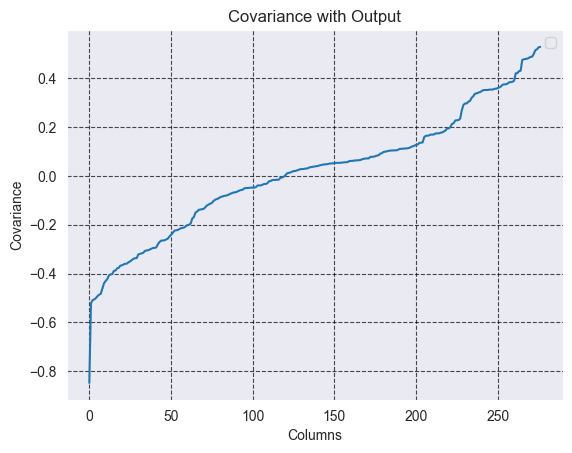

In [34]:
sns.lineplot(Train_1.drop(columns = ['CropCode']).corrwith(Train_1.CropCode).sort_values().values)
sns.set_style("darkgrid")
plt.title("Covariance with Output")
plt.grid(True,color='Black',linestyle='--', alpha=0.7)
plt.xlabel('Columns')
plt.ylabel('Covariance')
plt.legend()

In [36]:
month_id = 8
month_features = [feature for feature in Train_processed.columns if  re.match(fr'{month_id}', feature)]
len(month_features)

15

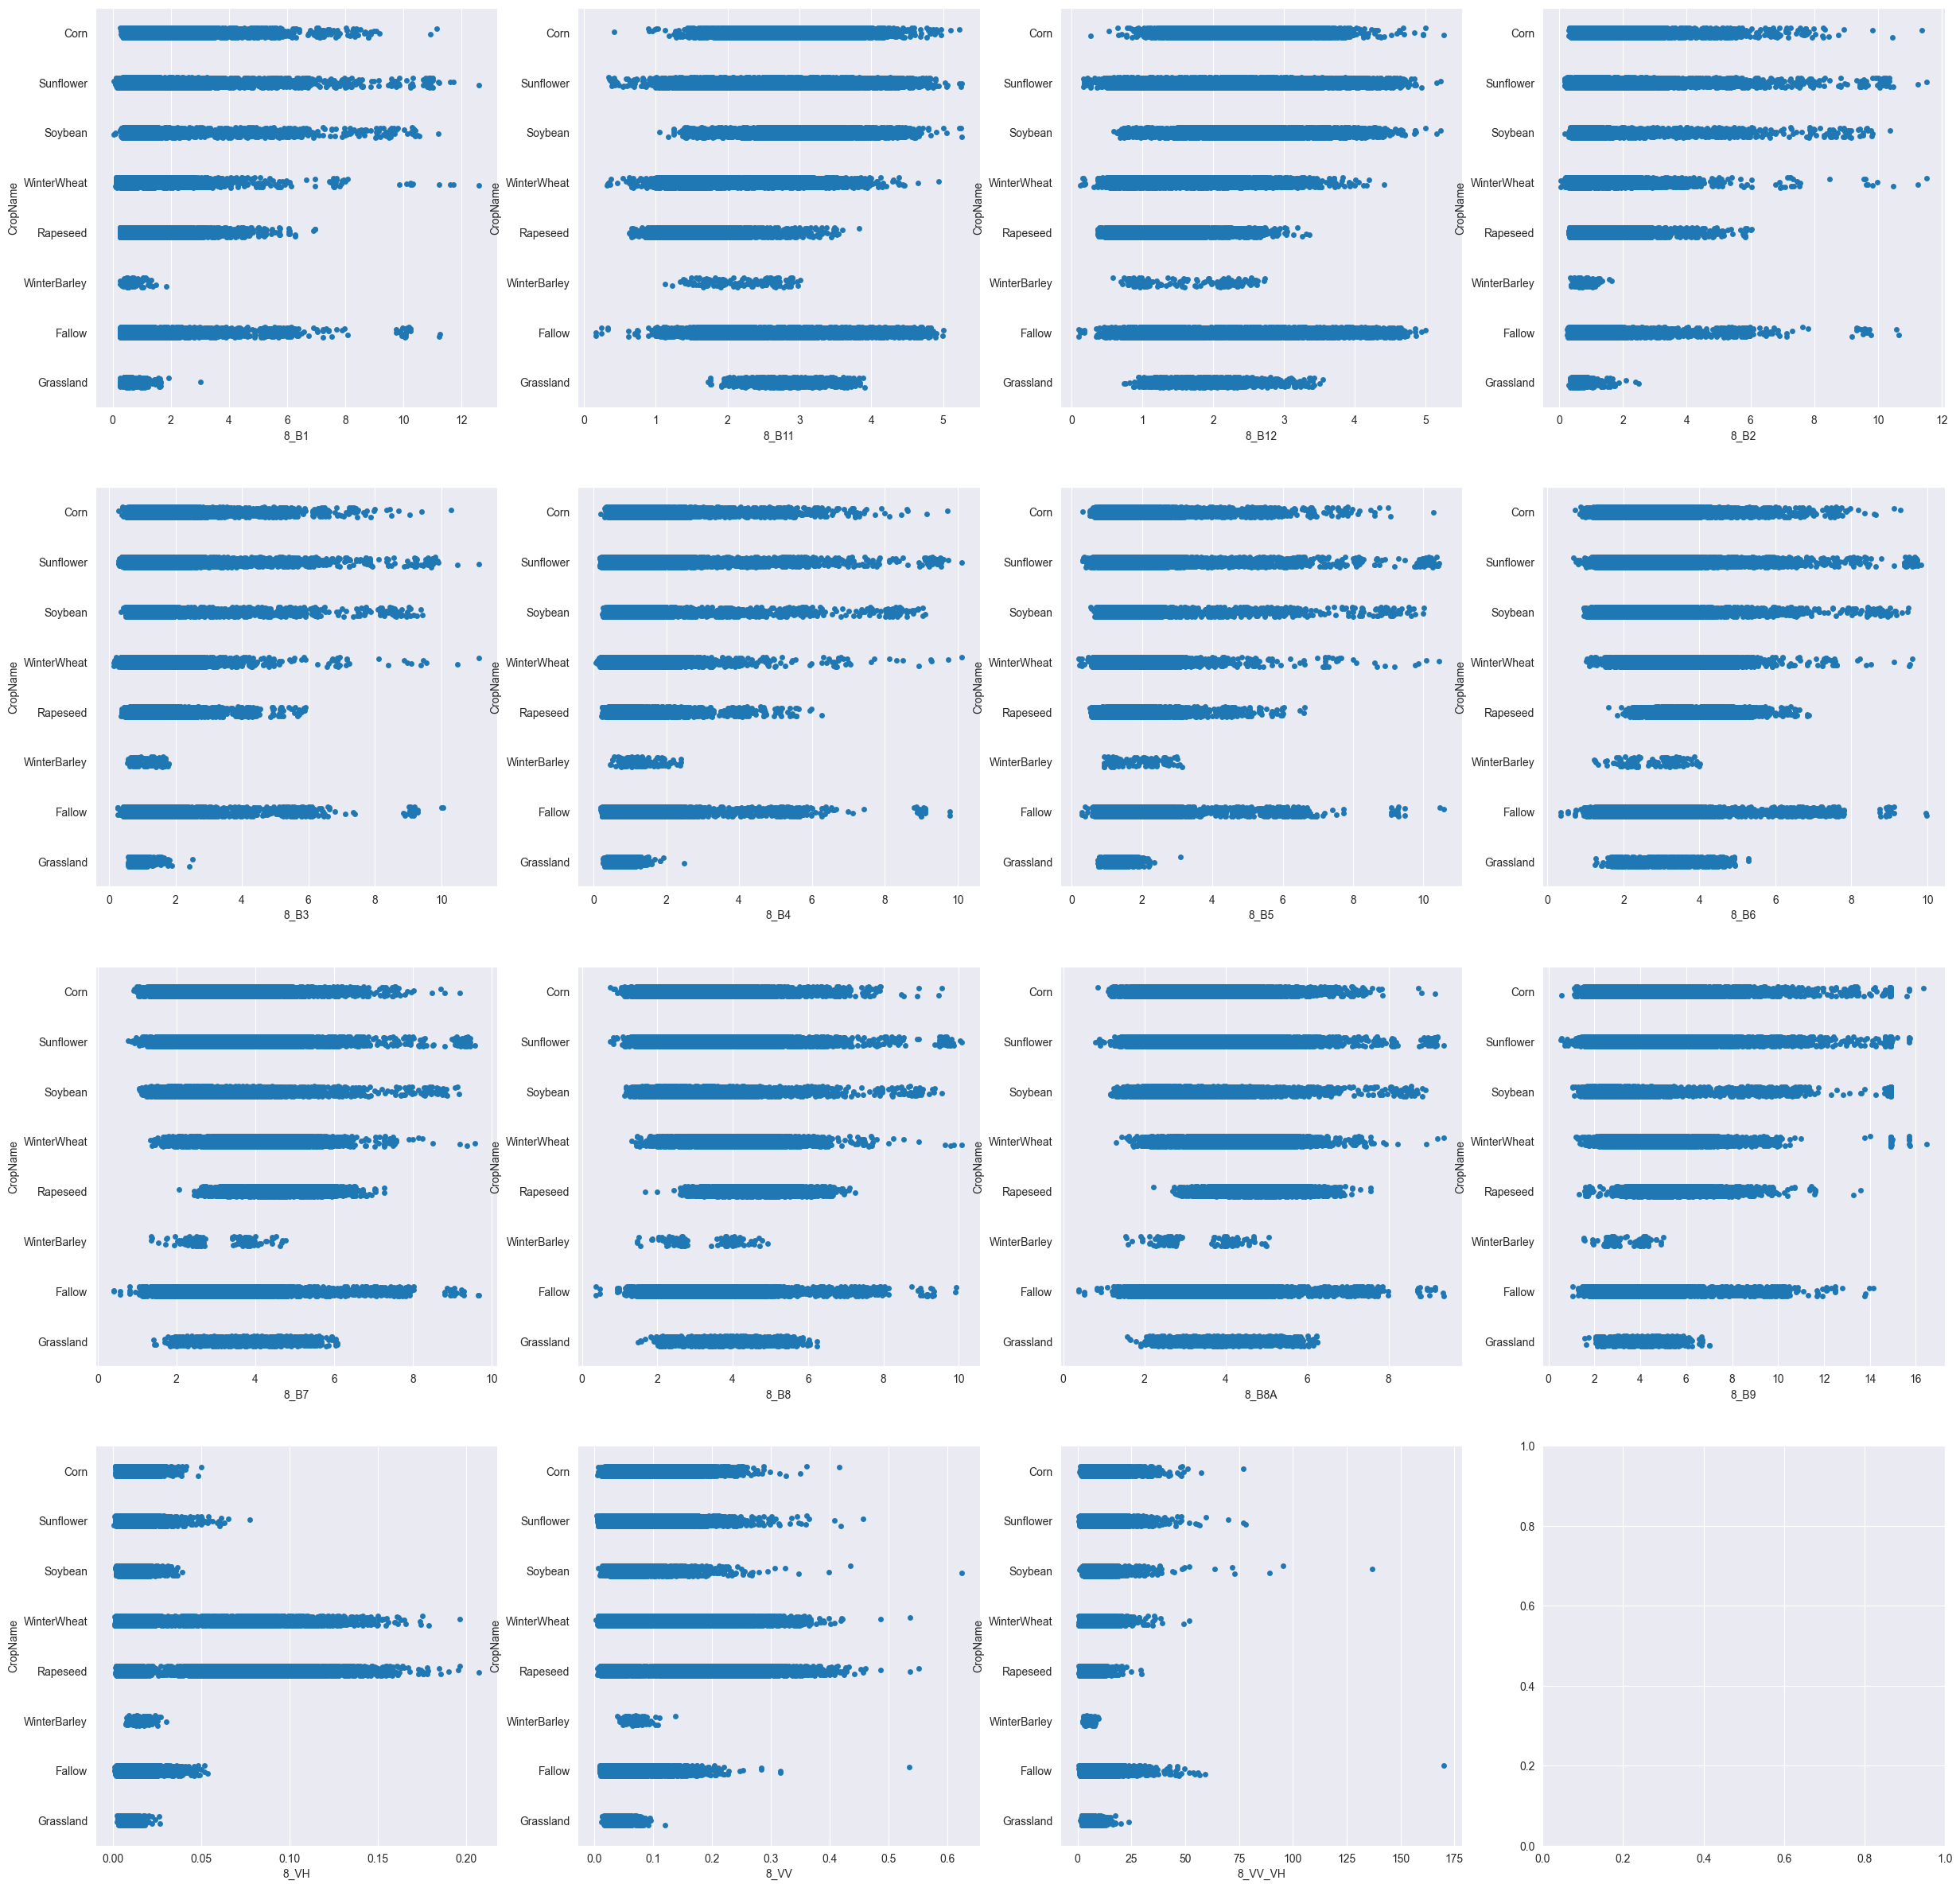

In [37]:
fig, ax = plt.subplots(4, 4, figsize=(30, 30))
for variable, subplot in zip(Train_processed[month_features], ax.flatten()):
    sns.stripplot(x = Train_processed[variable], y = Train_processed['CropName'], ax=subplot)